**GeekHub 2018-2019 DL workshop. 2nd part**

In this part we will find simpler way to classify images with the pretrained models. And will improve quality with the augmentation.

Lets'go.

In [0]:
!pip install imgaug
# next line to remove problem of numpy dependencies on some machines
!pip install --upgrade scikit-image

Requirement already up-to-date: scikit-image in /usr/local/lib/python3.6/dist-packages (0.14.2)


In [0]:
import numpy as np
from keras import layers, initializers, optimizers, regularizers
from keras import datasets, models, callbacks, applications, utils
import matplotlib.pyplot as plt
import tensorflow as tf
from imgaug import augmenters as iaa

from PIL import Image
import os
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


This time we will play with the synthetic LEGO images. Important that images are much bigger. But still small enough for quick tests.

In [0]:
!wget https://dl.dropboxusercontent.com/s/6jkj9txsd6cqkow/LEGO%20brick%20images.zip
!unzip -q "LEGO brick images.zip"
# !ls -l 'LEGO brick images/32123 half Bush'

--2019-03-14 13:26:27--  https://dl.dropboxusercontent.com/s/6jkj9txsd6cqkow/LEGO%20brick%20images.zip
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.8.6, 2620:100:601b:6::a27d:806
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.8.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91010364 (87M) [application/zip]
Saving to: ‘LEGO brick images.zip.3’

LEGO brick images.z 100%[===================>]  86.79M  54.0MB/s    in 1.6s    

2019-03-14 13:26:29 (54.0 MB/s) - ‘LEGO brick images.zip.3’ saved [91010364/91010364]

replace LEGO brick images/11214 Bush 3M friction with Cross axle/201706171006-0001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


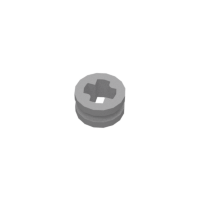

In [0]:
Image.open('LEGO brick images/32123 half Bush/201706171506-0001.png')

Lets collect all types of labels and all files we have in dataset.
And also lets divide it to the train/val/test datasets.

Will load everything to memory just for simplicity. In real cases this is bad idea.

In [0]:
root_path = 'LEGO brick images'

labels = []
for filename in os.listdir(root_path):
    if os.path.isdir(os.path.join(os.path.abspath(root_path), filename)): 
        labels.append(filename)
        
print("classes:", labels)

X = []
y = []

for label in range(len(labels)):
  d = (os.path.join(os.path.abspath(root_path), labels[label]))
  for filename in sorted(os.listdir(d)):
    y.append(label)
    X.append(np.asarray(Image.open(os.path.join(d, filename)))[:, :, :3]) #remove alpha channel

print("overall images:", len(X))

X = np.stack(X).astype(np.float32)/255.0

X_train, X_test_all, y_train, y_test_all = train_test_split(X, y, test_size=0.5, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_all, y_test_all, test_size=0.5, random_state=42)

del X
del y
del X_test_all
del y_test_all

classes: ['6632 Technic Lever 3M', '32123 half Bush', '3673 Peg 2M', '3069 Flat Tile 1x2', '3040 Roof Tile 1x2x45deg', '3004 Brick 1x2', '2357 Brick corner 1x2x2', '3023 Plate 1x2', '3022 Plate 2x2', '3024 Plate 1x1', '3794 Plate 1X2 with 1 Knob', '3713 Bush for Cross Axle', '3005 Brick 1x1', '18651 Cross Axle 2M with Snap friction', '3003 Brick 2x2', '11214 Bush 3M friction with Cross axle']
overall images: 6379


Now we can take a look on our images.

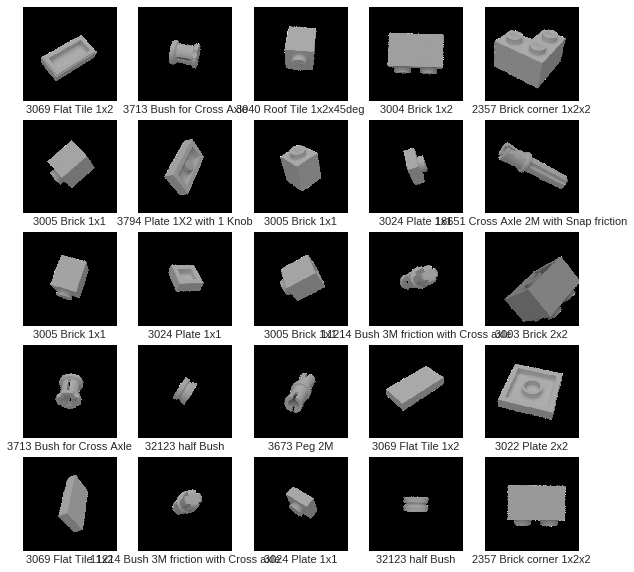

In [0]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(labels[y_train[i]])
plt.show()

This time instead of creating of our own model we will use external model. Easiest way is to take model from `keras.applications`.

In [0]:
model = applications.ResNet50(weights=None, input_shape=(200, 200, 3), classes=len(labels))

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          batch_size=16,
          epochs=15,
          callbacks=[
              callbacks.ModelCheckpoint('weights.h5', verbose=1, save_best_only=True, save_weights_only=True),
              callbacks.ReduceLROnPlateau(patience=2, verbose=1),
              callbacks.EarlyStopping(patience=4, verbose=1)
          ]
         )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 3189 samples, validate on 1595 samples
Epoch 1/15
3189/3189 [==============================] - 134s 42ms/step - loss: 1.6043 - acc: 0.4907 - val_loss: 11.3847 - val_acc: 0.1599

Epoch 00001: val_loss improved from inf to 11.38467, saving model to weights.h5
Epoch 2/15
3189/3189 [==============================] - 117s 37ms/step - loss: 0.9477 - acc: 0.6670 - val_loss: 5.2687 - val_acc: 0.3185

Epoch 00002: val_loss improved from 11.38467 to 5.26869, saving model to weights.h5
Epoch 3/15
3189/3189 [==============================] - 117s 37ms/step - loss: 0.7708 - acc: 0.7391 - val_loss: 4.5492 - val_acc: 0.4226

Epoch 00003: val_loss improved from 5.26869 to 4.54916, saving model to weights.h5
Epoch 4/15
3189/3189 [==============================] - 118s 37ms/step - loss: 0.6131 - acc: 0.7839 - val_loss: 5.4402 - val_acc: 0.3373

Epoch 00004: val_loss did not im

In [0]:
model.evaluate(X_test, y_test)

1595/1595 [==============================] - 14s 9ms/step


[0.08383505404182362, 0.973040752724794]

Accuracy is 97.7% on test set. Very impressive.

But we used only 3189 images for training and it is already was not very quick.
What if you have millions of images?
How we can speed process.

Solution comes from the idea that all images has a lot of common, so we can use learned features on big natural images dataset.
And we can train only top level features which describe space of our images.
In Keras it is easy to implement.

In [0]:
X_train = X_train*2-1
X_val = X_val*2-1
X_test = X_test*2-1

In [0]:
#pretrained model without top layer
base_model = applications.ResNet50(include_top=False, weights='imagenet', input_shape=(200, 200, 3), pooling='avg')
#fix weights
base_model.trainable = False

#and our model become simple
inp = layers.Input((200, 200, 3))
resnet = base_model(inp)

fc = layers.Dense(len(labels))(resnet)
fc = layers.Activation('softmax')(fc)

model = models.Model(inp, fc)

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#train only dense layer on top
model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          batch_size=16,
          epochs=1,
          callbacks=[
              callbacks.ModelCheckpoint('weights.h5', verbose=1, save_best_only=True, save_weights_only=True),
              callbacks.ReduceLROnPlateau(patience=2, verbose=1),
              callbacks.EarlyStopping(patience=4, verbose=1)
          ]
         )


#unfreeze all weights and train 
base_model.trainable = True
model.compile(optimizer=optimizers.Adam(1e-4), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          batch_size=16,
          epochs=10,
          callbacks=[
              callbacks.ModelCheckpoint('weights.h5', verbose=1, save_best_only=True, save_weights_only=True),
              callbacks.ReduceLROnPlateau(patience=2, verbose=1),
              callbacks.EarlyStopping(patience=4, verbose=1)
          ]
         )

Train on 3189 samples, validate on 1595 samples
Epoch 1/1
3189/3189 [==============================] - 46s 14ms/step - loss: 1.2169 - acc: 0.6221 - val_loss: 3.2935 - val_acc: 0.0727

Epoch 00001: val_loss improved from inf to 3.29347, saving model to weights.h5
Train on 3189 samples, validate on 1595 samples
Epoch 1/10
3189/3189 [==============================] - 137s 43ms/step - loss: 0.3889 - acc: 0.8639 - val_loss: 0.3236 - val_acc: 0.8853

Epoch 00001: val_loss improved from inf to 0.32361, saving model to weights.h5
Epoch 2/10
3189/3189 [==============================] - 117s 37ms/step - loss: 0.1249 - acc: 0.9567 - val_loss: 0.2244 - val_acc: 0.9266

Epoch 00002: val_loss improved from 0.32361 to 0.22441, saving model to weights.h5
Epoch 3/10
3189/3189 [==============================] - 117s 37ms/step - loss: 0.0676 - acc: 0.9777 - val_loss: 0.4060 - val_acc: 0.8571

Epoch 00003: val_loss did not improve from 0.22441
Epoch 4/10
3189/3189 [==============================] - 116s 3

In [0]:
model.evaluate(X_test, y_test)

1595/1595 [==============================] - 13s 8ms/step


[0.031716630544782055, 0.9880877746683677]

With the less amount of epochs we got even better result - 99% accuracy.



---


What else can we do?

Let's try to make our algorithm more stable by extending dataset.
For this you can go to childroom and make some photos of LEGO :)
Other way is to make some modification of images each time we use it in training - thats caled **augmentation**.

We will implement it with Keras `Sequence` subclassing and with the library `imgaug`.


In [0]:
class AugmentedSequence(utils.Sequence):
  def __init__(self, X, y, batch_size):
    self.X = np.array(X)
    self.y = np.array(y)
    self.batch_size = batch_size
    
    #for shuffling
    self.ids = np.random.permutation(range(len(X)))
    
    #for augmentation
    self.seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.Affine(scale=(0.8, 1.2), translate_percent=(-0.2, 0.2), rotate=(-15, 15))
    ])
    
  def __len__(self):
    return int(np.ceil(len(self.X)/float(self.batch_size)))
  
  def __getitem__(self, index):
    start = index * self.batch_size
    end = np.minimum((index + 1) * self.batch_size, len(self.X))
    
    ids = self.ids[start:end]
    
    batchX = self.X[ids]
    batchy = self.y[ids]
    
    batchX = self.seq.augment_images(batchX)
    
    return np.array(batchX), np.array(batchy)
  
  def on_epoch_end(self):    
    self.ids = np.random.permutation(range(len(self.X)))
    
    

And now lets try to repeat absolutely the same training, just by using `fit_generator` and our sequence.

In [0]:
#pretrained model without top layer
base_model = applications.ResNet50(include_top=False, weights='imagenet', input_shape=(200, 200, 3), pooling='avg')
#fix weights
base_model.trainable = False

#and our model become simple
inp = layers.Input((200, 200, 3))
resnet = base_model(inp)

fc = layers.Dense(len(labels))(resnet)
fc = layers.Activation('softmax')(fc)

model = models.Model(inp, fc)

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

generator = AugmentedSequence(X_train, y_train, 16)

#train only dense layer on top
model.fit_generator(generator,
          validation_data=(X_val, y_val),
          epochs=1,
          callbacks=[
              callbacks.ModelCheckpoint('weights.h5', verbose=1, save_best_only=True, save_weights_only=True),
              callbacks.ReduceLROnPlateau(patience=2, verbose=1),
              callbacks.EarlyStopping(patience=4, verbose=1)
          ]
         )


#unfreeze all weights and train 
base_model.trainable = True
model.compile(optimizer=optimizers.Adam(1e-4), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit_generator(generator,
          validation_data=(X_val, y_val),
          epochs=10,
          callbacks=[
              callbacks.ModelCheckpoint('weights.h5', verbose=1, save_best_only=True, save_weights_only=True),
              callbacks.ReduceLROnPlateau(patience=2, verbose=1),
              callbacks.EarlyStopping(patience=4, verbose=1)
          ]
         )

Epoch 1/1
200/200 [==============================] - 52s 258ms/step - loss: 1.4828 - acc: 0.5235 - val_loss: 3.3032 - val_acc: 0.0727

Epoch 00001: val_loss improved from inf to 3.30325, saving model to weights.h5
Epoch 1/10
200/200 [==============================] - 140s 702ms/step - loss: 0.5202 - acc: 0.8127 - val_loss: 1.0858 - val_acc: 0.6959

Epoch 00001: val_loss improved from inf to 1.08576, saving model to weights.h5
Epoch 2/10
200/200 [==============================] - 118s 588ms/step - loss: 0.2781 - acc: 0.9000 - val_loss: 0.7174 - val_acc: 0.7724

Epoch 00002: val_loss improved from 1.08576 to 0.71743, saving model to weights.h5
Epoch 3/10
200/200 [==============================] - 119s 595ms/step - loss: 0.2261 - acc: 0.9112 - val_loss: 0.3499 - val_acc: 0.8846

Epoch 00003: val_loss improved from 0.71743 to 0.34992, saving model to weights.h5
Epoch 4/10
200/200 [==============================] - 118s 590ms/step - loss: 0.1750 - acc: 0.9365 - val_loss: 0.4670 - val_acc: 0

In [0]:
model.evaluate(X_test, y_test)

1595/1595 [==============================] - 12s 8ms/step


[0.08613780146599002, 0.9699059564865495]

Accuracy is less this time, because usually you need more epochs when you use augmentation.
And our synthetic dataset alrady has a lot of rotations, so it is not so helpful here.

But anyway you should remember this approach - it is very helpful for generalization.